In [30]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
# Suppress specific UserWarnings
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
warnings.simplefilter("ignore", ConvergenceWarning)

In [31]:
# file path
file_path = 'physicians-in-canada-1971-2022.xlsx'

# Specify the range of columns and rows to read (I was getting NaN where there was no real blanks) 
columns_range = 'A:BH'
num_rows = 101698

# Read the specific range from the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='Table 1 Physician workforce', usecols=columns_range, nrows=num_rows)

# Replace NaN values in Health region column with the corresponding 'Jurisdiction' values to simplify the filtering by province
df['Health region'] = df.apply(
    lambda row: row['Jurisdiction'] if pd.isna(row['Health region']) else row['Health region'],
    axis=1
)

# Display the DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101697 entries, 0 to 101696
Data columns (total 60 columns):
 #   Column                                                         Non-Null Count   Dtype  
---  ------                                                         --------------   -----  
 0   Year                                                           101697 non-null  int64  
 1   Jurisdiction                                                   101697 non-null  object 
 2   Health region                                                  101697 non-null  object 
 3   Specialty                                                      101697 non-null  object 
 4   Specialty sort                                                 101697 non-null  int64  
 5   Physician-to–100,000 population ratio                          100173 non-null  float64
 6   Number of physicians                                           101697 non-null  int64  
 7   Number male                                    

In [32]:
# get more info about the dataset
df.describe()

,Year,Specialty sort,"Physician-to–100,000 population ratio",Number of physicians,Number male,Number female,Number sex unknown,Average age,Median age,Age group: Younger than 30,...,Years since graduation: 16–20,Years since graduation: 21–25,Years since graduation: 26–30,Years since graduation: 31–35,Years since graduation: 36 and more,Years since graduation: Unknown,Median years since graduation,Number of physicians who returned from abroad,Number of physicians who moved abroad,Statistics Canada population
count,101697.000000,101697.000000,100173.000000,101697.000000,101697.000000,101697.000000,101697.000000,101697.000000,101697.000000,101697.000000,...,101697.000000,101697.000000,101697.000000,101697.000000,101697.000000,101697.000000,101697.000000,97462.000000,97462.000000,1.001730e+05
mean,2008.164626,38.367415,17.623830,287.697946,197.895631,88.871982,0.930332,48.787534,48.148038,7.976233,...,38.109807,34.853113,30.460171,25.286252,38.895533,22.911934,21.795314,1.179885,1.488683,2.167754e+06
std,11.271407,27.442971,41.087411,2097.332677,1414.751327,730.538473,16.021737,6.619543,7.277820,86.801274,...,279.430855,262.436833,237.133919,204.970378,343.914697,254.332246,7.415711,8.785969,12.916201,5.573675e+06
min,1971.000000,1.000000,0.002569,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.280000e+03
25%,2003.000000,11.000000,0.750006,3.000000,2.000000,1.000000,0.000000,45.300000,44.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,2.244960e+05
50%,2010.000000,33.000000,2.251064,11.000000,8.000000,3.000000,0.000000,48.800000,48.000000,0.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,21.500000,0.000000,0.000000,5.666610e+05
75%,2017.000000,65.000000,7.874029,60.000000,42.000000,16.000000,0.000000,51.900000,52.000000,0.000000,...,8.000000,8.000000,6.000000,5.000000,7.000000,1.000000,26.000000,0.000000,0.000000,1.232976e+06
max,2022.000000,83.000000,534.975485,96020.000000,52804.000000,43209.000000,1222.000000,90.000000,90.000000,3452.000000,...,11057.000000,10512.000000,10149.000000,9531.000000,19692.000000,12438.000000,63.000000,360.000000,678.000000,3.892990e+07


In [33]:
# Show size of the dataset
print("The size of the dataset is: ", df.shape)

# Displaying the data types of each column 
print(pd.Series(df.dtypes).value_counts())


The size of the dataset is:  (101697, 60)
int64      49
float64     7
object      4
Name: count, dtype: int64


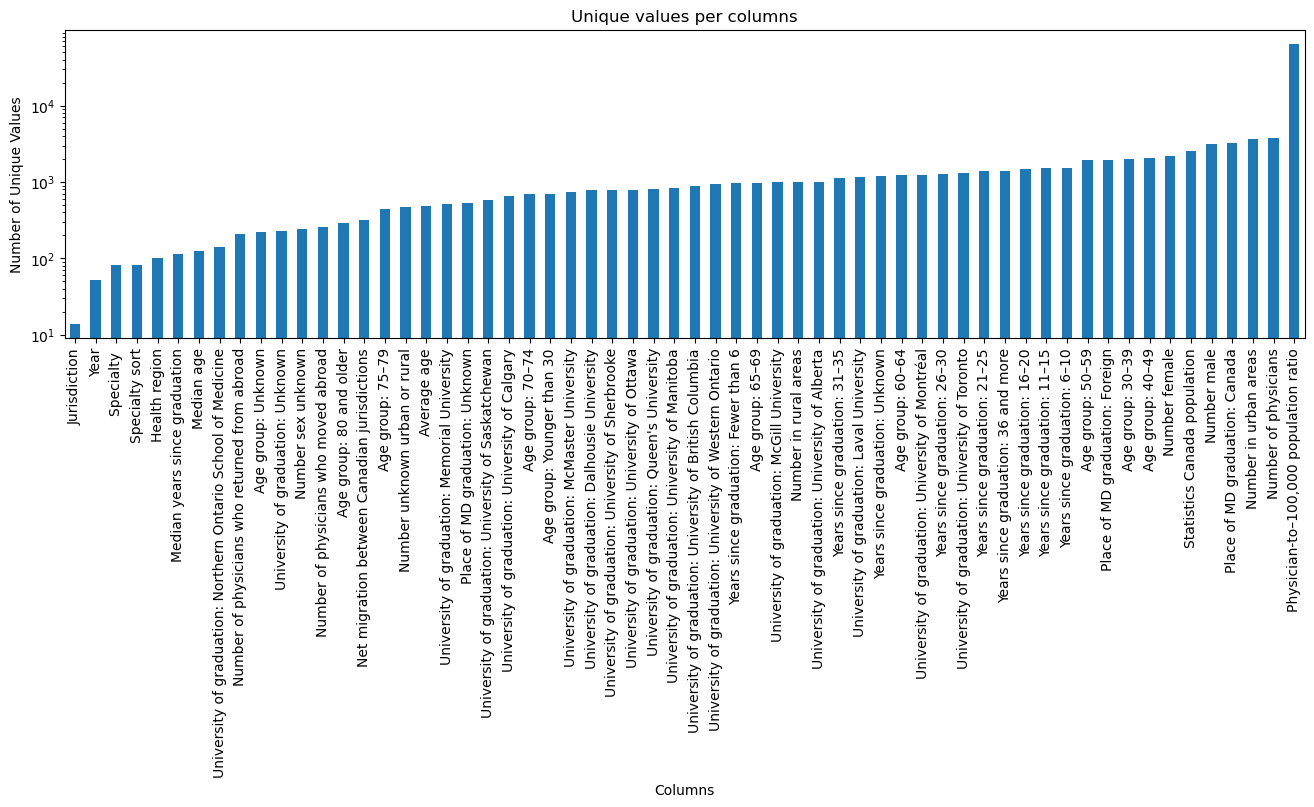

In [34]:
# Compute number of unique entries for each feature
unique_values = df.nunique().sort_values()

# Plot information with y-axis 
unique_values.plot.bar(logy=True, figsize=(16, 4), 
                       title="Unique values per columns")
plt.ylabel('Number of Unique Values')
plt.xlabel('Columns')
plt.show()

In [35]:
# Check for duplicates
duplicate_rows = df.duplicated()

# Print the total number of duplicates
print("Total number of duplicates:", duplicate_rows.sum())

Total number of duplicates: 0


In [36]:
# Check for missing values
missing_values = df.isnull()

# Count the number of missing values in each column
missing_counts = missing_values.sum()

# Print the columns with missing values and their counts
print("Columns with missing values and their counts:")
for column, count in missing_counts.items():
    print(f"{column}: {count}")

# Print the total number of missing values
print("Total number of missing values:", missing_counts.sum())


Columns with missing values and their counts:
Year: 0
Jurisdiction: 0
Health region: 0
Specialty : 0
Specialty sort: 0
Physician-to–100,000 population ratio: 1524
Number of physicians: 0
Number male: 0
Number female: 0
Number sex unknown: 0
Average age: 0
Median age: 0
Age group: Younger than 30: 0
Age group: 30–39: 0
Age group: 40–49: 0
Age group: 50–59: 0
Age group: 60–64: 0
Age group: 65–69: 0
Age group: 70–74: 0
Age group: 75–79: 0
Age group: 80 and older: 0
Age group: Unknown: 0
Number in rural areas: 0
Number in urban areas: 0
Number unknown urban or rural: 0
Place of MD graduation: Canada: 0
Place of MD graduation: Foreign: 0
Place of MD graduation: Unknown: 0
University of graduation: Memorial University: 0
University of graduation: Dalhousie University: 0
University of graduation: Laval University: 0
University of graduation: McGill University: 0
University of graduation: University of Montréal: 0
University of graduation: University of Sherbrooke: 0
University of graduation: 

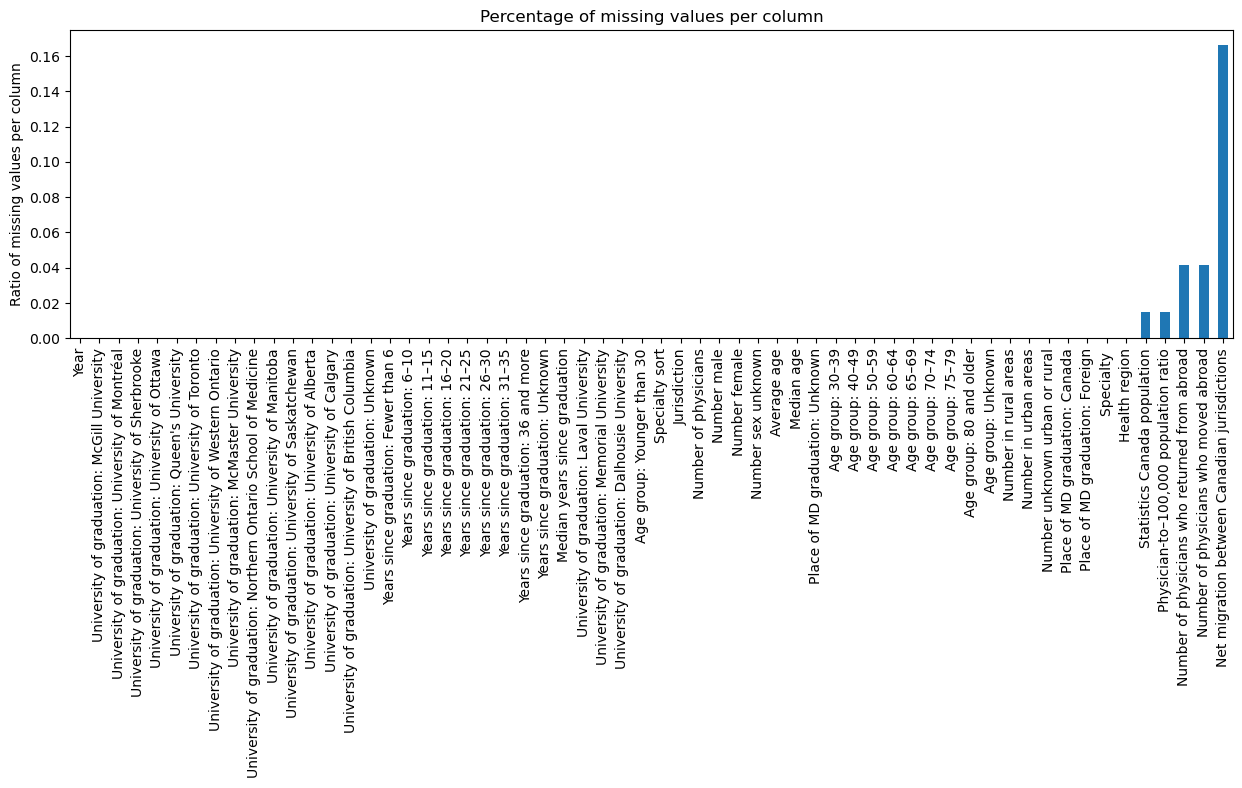

In [37]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per column",
    ylabel="Ratio of missing values per column");

In [38]:
# Create Family medicine in NB & Canada dataframes for EDA , Descriptive analysis & ML

## New-Brunswick ##

# Create the dataframe for 'N.B.' jurisdiction and 'Family medicine' specialty
family_medicine_df_nb = df[
    (df['Specialty sort'] == 3) & 
    (
        ((df['Jurisdiction'] == 'N.B.') & (df['Health region'] == 'N.B.'))
    )
]

#Checking the NaN values family_medicine_df_nb
missing_values_family_medecine_df_nb = family_medicine_df_nb.isnull()

# Count the number of missing values in each column family_medicine_df_nb
missing_values_family_medecine_df_nb = missing_values_family_medecine_df_nb.sum()

# Print the columns with missing values and their counts family_medicine_df_nb
print("Columns with missing values in family_medicine_df_nb and the count:")
print(missing_values_family_medecine_df_nb[missing_values_family_medecine_df_nb > 0])

# Print the total number of missing values family_medicine_df_nb
print("Total number of missing values in family_medicine_df_nb:", missing_values_family_medecine_df_nb.sum())

## Canada ##

# Create the dataframe for 'Canada' jurisdiction and 'Family medicine' specialty
family_medicine_df_canada = df[
    (df['Specialty sort'] == 3) & 
    (
        ((df['Jurisdiction'] == 'Canada') & (df['Health region'] == 'Canada'))
    )
]

#Checking the NaN values family_medicine_df_canada
missing_values_family_medecine_df_canada = family_medicine_df_canada.isnull()

# Count the number of missing values in each column family_medicine_df_canada
missing_values_family_medecine_df_canada = missing_values_family_medecine_df_canada.sum()

# Print the columns with missing values and their counts family_medicine_df_canada
print("Columns with missing values in family_medicine_df_canada and the count:")
print(missing_values_family_medecine_df_canada[missing_values_family_medecine_df_canada > 0])

# Print the total number of missing values family_medicine_df_canada
print("Total number of missing values in family_medicine_df_canada:", missing_values_family_medecine_df_canada.sum())

Columns with missing values in family_medicine_df_nb and the count:
Number of physicians who returned from abroad     1
Number of physicians who moved abroad             1
Net migration between Canadian jurisdictions     30
dtype: int64
Total number of missing values in family_medicine_df_nb: 32
Columns with missing values in family_medicine_df_canada and the count:
Number of physicians who returned from abroad     1
Number of physicians who moved abroad             1
Net migration between Canadian jurisdictions     30
dtype: int64
Total number of missing values in family_medicine_df_canada: 32


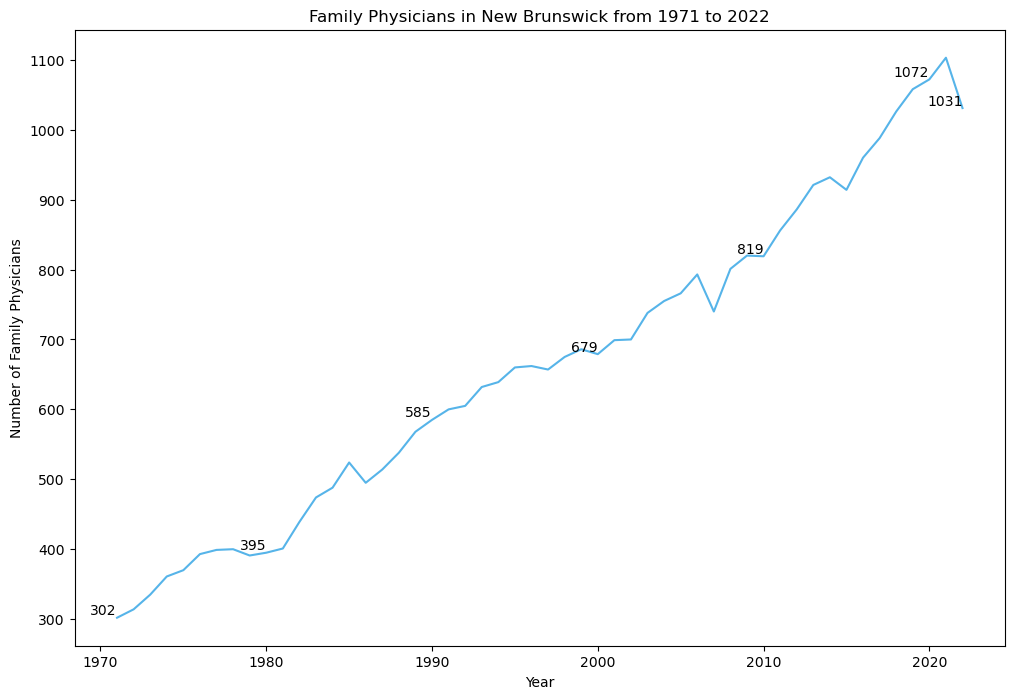

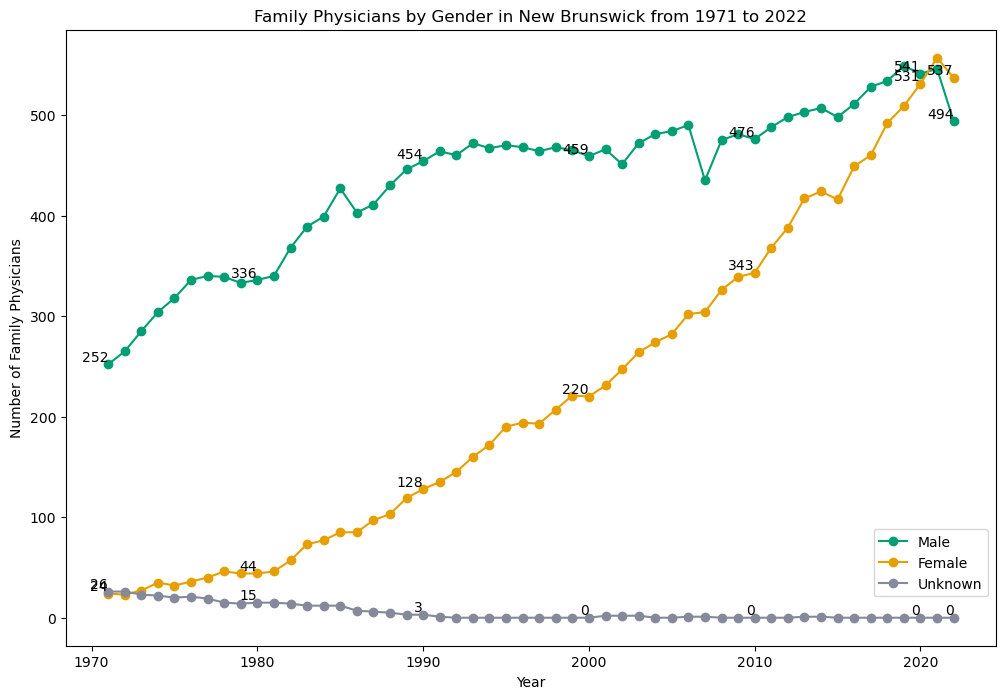

In [39]:
## Display & plot the number of family physicians in NB from 1971 to 2022

# Group by year and sum the number of physicians
nb_family_medicine_by_year = family_medicine_df_nb.groupby('Year')['Number of physicians'].sum()

# Plotting
plt.figure(figsize=(12, 8))

# Plot the number of family physicians over the years
plt.plot(nb_family_medicine_by_year.index, nb_family_medicine_by_year.values,color='#56B4E9')

# Add data labels for every 10 years
for year, number in zip(nb_family_medicine_by_year.index, nb_family_medicine_by_year.values):
    if year % 10 == 0:  # Add label for every 10 years
        plt.text(year, number, f'{number}', ha='right', va='bottom')

# Add data labels for the first and last years
plt.text(nb_family_medicine_by_year.index[0], nb_family_medicine_by_year.values[0], f'{nb_family_medicine_by_year.values[0]}', ha='right', va='bottom')
plt.text(nb_family_medicine_by_year.index[-1], nb_family_medicine_by_year.values[-1], f'{nb_family_medicine_by_year.values[-1]}', ha='right', va='bottom')

plt.title('Family Physicians in New Brunswick from 1971 to 2022')
plt.xlabel('Year')
plt.ylabel('Number of Family Physicians')
plt.grid(False)
plt.show()

## Display the number of family physicians in NB from 1971 to 2022 by Gender 

# Group by year and sum the number of physicians for each gender category
nb_family_medicine_by_year = family_medicine_df_nb.groupby('Year').agg({
    'Number male': 'sum',
    'Number female': 'sum',
    'Number sex unknown': 'sum'
})

# Plotting
plt.figure(figsize=(12, 8))

# Plot the number of male family physicians
plt.plot(nb_family_medicine_by_year.index, nb_family_medicine_by_year['Number male'], marker='o', color='#009E73', label='Male')

# Plot the number of female family physicians
plt.plot(nb_family_medicine_by_year.index, nb_family_medicine_by_year['Number female'], marker='o', color='#E69F00', label='Female')

# Plot the number of physicians with unknown gender
plt.plot(nb_family_medicine_by_year.index, nb_family_medicine_by_year['Number sex unknown'], marker='o', color='#858999', label='Unknown')

# Add data labels for every 10 years
for year in nb_family_medicine_by_year.index:
    for gender in ['Number male', 'Number female', 'Number sex unknown']:
        number = nb_family_medicine_by_year[gender].loc[year]
        if year % 10 == 0:  # Add label for every 10 years
            plt.text(year, number, f'{number}', ha='right', va='bottom')

# Add data labels for the first and last years
for gender in ['Number male', 'Number female', 'Number sex unknown']:
    plt.text(nb_family_medicine_by_year.index[0], nb_family_medicine_by_year[gender].iloc[0], f'{nb_family_medicine_by_year[gender].iloc[0]}', ha='right', va='bottom')
    plt.text(nb_family_medicine_by_year.index[-1], nb_family_medicine_by_year[gender].iloc[-1], f'{nb_family_medicine_by_year[gender].iloc[-1]}', ha='right', va='bottom')

plt.title('Family Physicians by Gender in New Brunswick from 1971 to 2022')
plt.xlabel('Year')
plt.ylabel('Number of Family Physicians')

# Add the legend at the bottom inside the chart area
plt.legend(loc='upper center', bbox_to_anchor=(0.93, 0.2), ncol=1)

plt.grid(False)
plt.show()


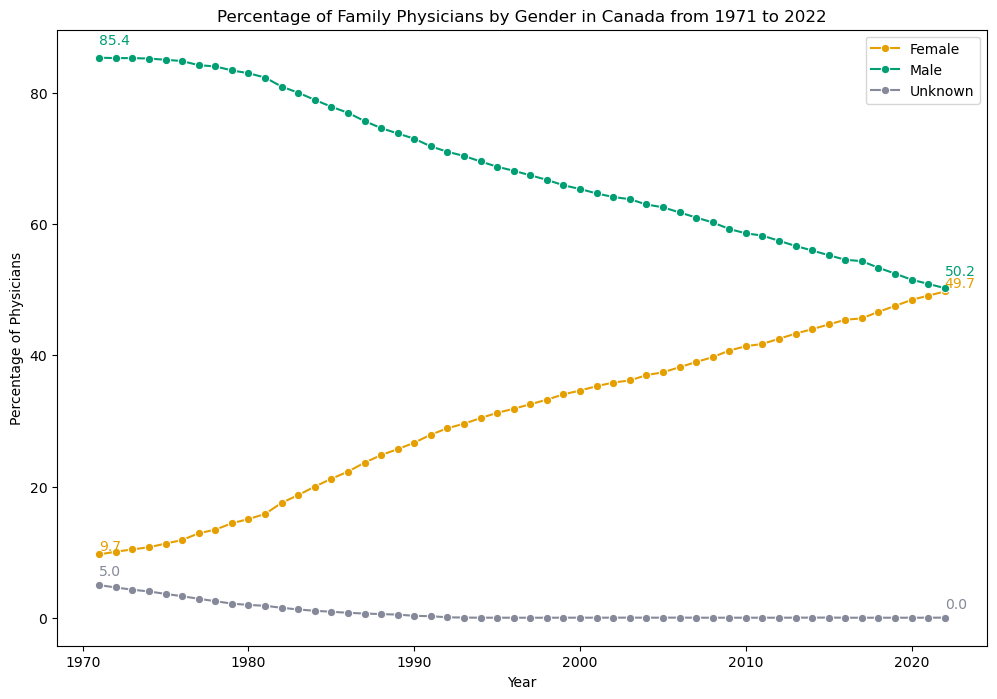

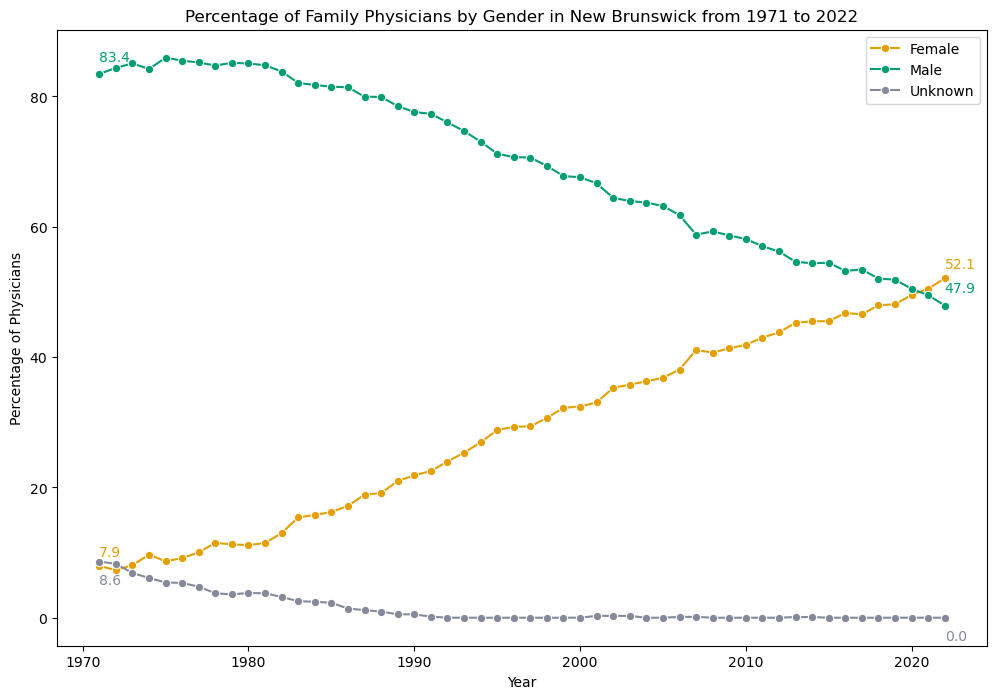

In [40]:
## Plot and display the percentage of family physcians by gender over time in Canada and New-Brunswick ##

# Function to annotate first and last points on the plot
def annotate_first_last(data, x, y, color, offset=0.5):
    first = data.iloc[0]
    last = data.iloc[-1]
    
    # Annotate the first point
    plt.text(first[x], first[y] + offset, f'{first[y]:.1f}', color=color, verticalalignment='bottom')
    
    # Annotate the last point
    plt.text(last[x], last[y] + offset, f'{last[y]:.1f}', color=color, verticalalignment='bottom')

## Canada ##

# Step 1: Filter the dataframe for the 'Family Medicine' specialty in Canada & make a copy to avoid SettingWithCopyWarning
family_medicine_df_canada = df[
    (df['Specialty sort'] == 3) & 
    (
        ((df['Jurisdiction'] == 'Canada') & (df['Health region'] == 'Canada'))
    )].copy()  

# Calculate the percentage of male physicians
family_medicine_df_canada["Percentage male"] = (family_medicine_df_canada["Number male"] / family_medicine_df_canada["Number of physicians"]) * 100

# Calculate the percentage of female physicians
family_medicine_df_canada["Percentage female"] = (family_medicine_df_canada["Number female"] / family_medicine_df_canada["Number of physicians"]) * 100

# Calculate the percentage of physicians whose gender is unknown
family_medicine_df_canada["Percentage unknown sex"] = (family_medicine_df_canada["Number sex unknown"] / family_medicine_df_canada["Number of physicians"]) * 100

# Step 2: Plotting
plt.figure(figsize=(12, 8))

# Plot percentage of female physicians 
sns.lineplot(data=family_medicine_df_canada, x='Year', y='Percentage female', color='#E69F00', marker='o', label='Female')
annotate_first_last(family_medicine_df_canada, 'Year', 'Percentage female', '#E69F00', offset=0.2)

# Plot percentage of male physicians 
sns.lineplot(data=family_medicine_df_canada, x='Year', y='Percentage male', color='#009E73', marker='o', label='Male')
annotate_first_last(family_medicine_df_canada, 'Year', 'Percentage male', '#009E73', offset=1.5)

# Plot percentage of physicians with unknown gender
sns.lineplot(data=family_medicine_df_canada, x='Year', y='Percentage unknown sex', color='#858999', marker='o', label='Unknown')
annotate_first_last(family_medicine_df_canada, 'Year', 'Percentage unknown sex', '#858999', offset=1)

plt.title('Percentage of Family Physicians by Gender in Canada from 1971 to 2022')
plt.xlabel('Year')
plt.ylabel('Percentage of Physicians')
plt.grid(False)
plt.legend()
plt.show()

## New-Brunswick ##

# Step 1: Filter the dataframe for the 'Family Medicine'specialty in New-Brunswick & make a copy to avoid SettingWithCopyWarning
family_medicine_df_nb = df[
    (df['Specialty sort'] == 3) & 
    (
        ((df['Jurisdiction'] == 'N.B.') & (df['Health region'] == 'N.B.'))
    )].copy()  

# Calculate the percentage of male physicians
family_medicine_df_nb["Percentage male"] = (family_medicine_df_nb["Number male"] / family_medicine_df_nb["Number of physicians"]) * 100

# Calculate the percentage of female physicians
family_medicine_df_nb["Percentage female"] = (family_medicine_df_nb["Number female"] / family_medicine_df_nb["Number of physicians"]) * 100

# Calculate the percentage of physicians whose sex is unknown
family_medicine_df_nb["Percentage unknown sex"] = (family_medicine_df_nb["Number sex unknown"] / family_medicine_df_nb["Number of physicians"]) * 100

# Step 2: Plotting
plt.figure(figsize=(12, 8))

# Plot percentage of female physicians 
sns.lineplot(data=family_medicine_df_nb, x='Year', y='Percentage female', color='#E69F00', marker='o', label='Female')
annotate_first_last(family_medicine_df_nb, 'Year', 'Percentage female', '#E69F00', offset=1)

# Plot percentage of male physicians 
sns.lineplot(data=family_medicine_df_nb, x='Year', y='Percentage male', color='#009E73', marker='o', label='Male')
annotate_first_last(family_medicine_df_nb, 'Year', 'Percentage male', '#009E73', offset=1.5)

# Plot percentage of physicians with unknown gender
sns.lineplot(data=family_medicine_df_nb, x='Year', y='Percentage unknown sex', color='#858999', marker='o', label='Unknown')
annotate_first_last(family_medicine_df_nb, 'Year', 'Percentage unknown sex', '#858999', offset=-4)

plt.title('Percentage of Family Physicians by Gender in New Brunswick from 1971 to 2022')
plt.xlabel('Year')
plt.ylabel('Percentage of Physicians')
plt.grid(False)
plt.legend()
plt.show()


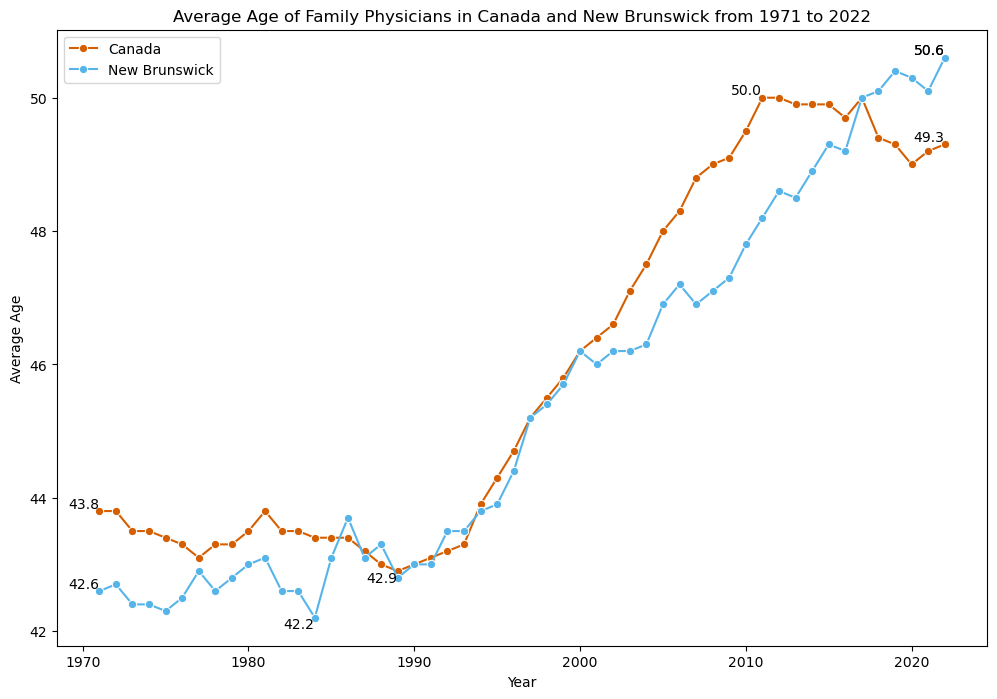

In [41]:
# Display and plot the average age of family physicians in Canada and New Brunswick over time

# Identify the points to annotate for Canada
first_year_canada = family_medicine_df_canada.iloc[0]
last_year_canada = family_medicine_df_canada.iloc[-1]
min_age_canada = family_medicine_df_canada.loc[family_medicine_df_canada['Average age'].idxmin()]
max_age_canada = family_medicine_df_canada.loc[family_medicine_df_canada['Average age'].idxmax()]

# Identify the points to annotate for New Brunswick
first_year_nb = family_medicine_df_nb.iloc[0]
last_year_nb = family_medicine_df_nb.iloc[-1]
min_age_nb = family_medicine_df_nb.loc[family_medicine_df_nb['Average age'].idxmin()]
max_age_nb = family_medicine_df_nb.loc[family_medicine_df_nb['Average age'].idxmax()]

# Plotting
plt.figure(figsize=(12, 8))

# Plot average age of physicians in Canada
sns.lineplot(data=family_medicine_df_canada, x='Year', y='Average age', marker='o', color='#D55E00', label='Canada')

# Annotate points for Canada
plt.text(first_year_canada['Year'], first_year_canada['Average age'], f'{first_year_canada["Average age"]:.1f}', verticalalignment='bottom', horizontalalignment='right')
plt.text(last_year_canada['Year'], last_year_canada['Average age'], f'{last_year_canada["Average age"]:.1f}', verticalalignment='bottom', horizontalalignment='right')
plt.text(min_age_canada['Year'], min_age_canada['Average age'], f'{min_age_canada["Average age"]:.1f}', verticalalignment='top', horizontalalignment='right')
plt.text(max_age_canada['Year'], max_age_canada['Average age'], f'{max_age_canada["Average age"]:.1f}', verticalalignment='bottom', horizontalalignment='right')

# Plot average age of physicians in New Brunswick
sns.lineplot(data=family_medicine_df_nb, x='Year', y='Average age', marker='o', color='#56B4E9', label='New Brunswick')

# Annotate points for New Brunswick
plt.text(first_year_nb['Year'], first_year_nb['Average age'], f'{first_year_nb["Average age"]:.1f}', verticalalignment='bottom', horizontalalignment='right')
plt.text(last_year_nb['Year'], last_year_nb['Average age'], f'{last_year_nb["Average age"]:.1f}', verticalalignment='bottom', horizontalalignment='right')
plt.text(min_age_nb['Year'], min_age_nb['Average age'], f'{min_age_nb["Average age"]:.1f}', verticalalignment='top', horizontalalignment='right')
plt.text(max_age_nb['Year'], max_age_nb['Average age'], f'{max_age_nb["Average age"]:.1f}', verticalalignment='bottom', horizontalalignment='right')

# Add plot title and labels
plt.title('Average Age of Family Physicians in Canada and New Brunswick from 1971 to 2022')
plt.xlabel('Year')
plt.ylabel('Average Age')
plt.grid(False)
plt.legend()

plt.show()


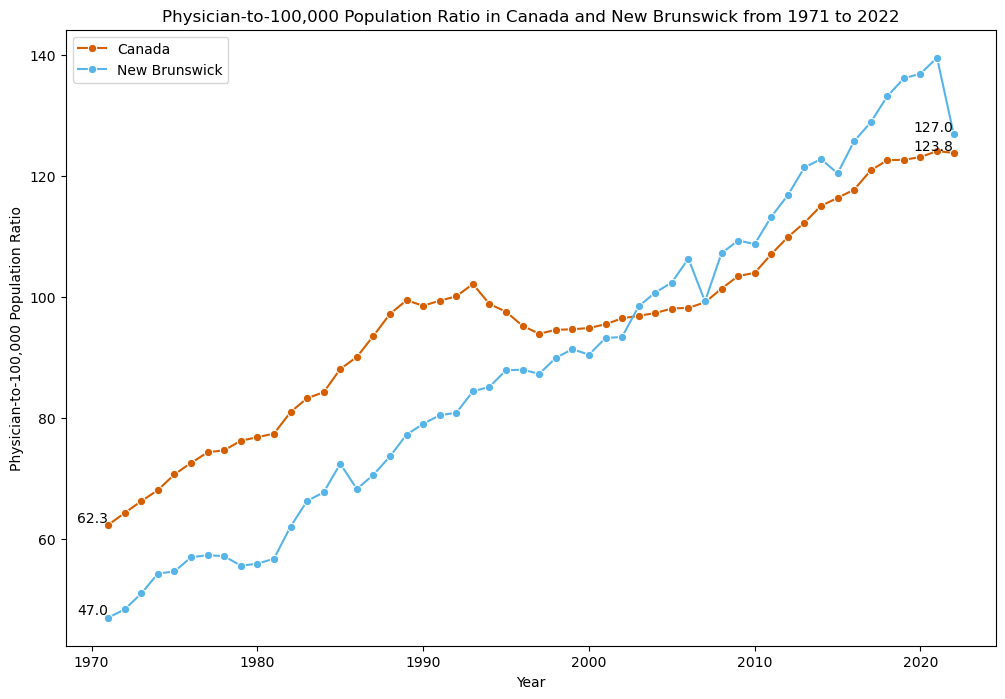

In [42]:
## Physician-to–100,000 population ratio for Canada vs. New Brunswick ##

# Identify the points to annotate for Canada
first_year_canada_ratio = family_medicine_df_canada.iloc[0]
last_year_canada_ratio = family_medicine_df_canada.iloc[-1]
min_ratio_canada = family_medicine_df_canada.loc[family_medicine_df_canada['Physician-to–100,000 population ratio'].idxmin()]
max_ratio_canada = family_medicine_df_canada.loc[family_medicine_df_canada['Physician-to–100,000 population ratio'].idxmax()]

# Identify the points to annotate for New Brunswick
first_year_nb_ratio = family_medicine_df_nb.iloc[0]
last_year_nb_ratio = family_medicine_df_nb.iloc[-1]
min_ratio_nb = family_medicine_df_nb.loc[family_medicine_df_nb['Physician-to–100,000 population ratio'].idxmin()]
max_ratio_nb = family_medicine_df_nb.loc[family_medicine_df_nb['Physician-to–100,000 population ratio'].idxmax()]

# Plotting
plt.figure(figsize=(12, 8))

# Plot physician-to-100,000 population ratio in Canada
sns.lineplot(data=family_medicine_df_canada, x='Year', y='Physician-to–100,000 population ratio', marker='o', color='#D55E00', label='Canada')

# Annotate points for Canada
plt.text(first_year_canada_ratio['Year'], first_year_canada_ratio['Physician-to–100,000 population ratio'], f'{first_year_canada_ratio["Physician-to–100,000 population ratio"]:.1f}', verticalalignment='bottom', horizontalalignment='right')
plt.text(last_year_canada_ratio['Year'], last_year_canada_ratio['Physician-to–100,000 population ratio'], f'{last_year_canada_ratio["Physician-to–100,000 population ratio"]:.1f}', verticalalignment='bottom', horizontalalignment='right')

# Plot physician-to-100,000 population ratio in New Brunswick
sns.lineplot(data=family_medicine_df_nb, x='Year', y='Physician-to–100,000 population ratio', marker='o', color='#56B4E9', label='New Brunswick')

# Annotate points for New Brunswick
plt.text(first_year_nb_ratio['Year'], first_year_nb_ratio['Physician-to–100,000 population ratio'], f'{first_year_nb_ratio["Physician-to–100,000 population ratio"]:.1f}', verticalalignment='bottom', horizontalalignment='right')
plt.text(last_year_nb_ratio['Year'], last_year_nb_ratio['Physician-to–100,000 population ratio'], f'{last_year_nb_ratio["Physician-to–100,000 population ratio"]:.1f}', verticalalignment='bottom', horizontalalignment='right')


# Add plot title and labels
plt.title('Physician-to-100,000 Population Ratio in Canada and New Brunswick from 1971 to 2022')
plt.xlabel('Year')
plt.ylabel('Physician-to-100,000 Population Ratio')
plt.grid(False)
plt.legend()

plt.show()


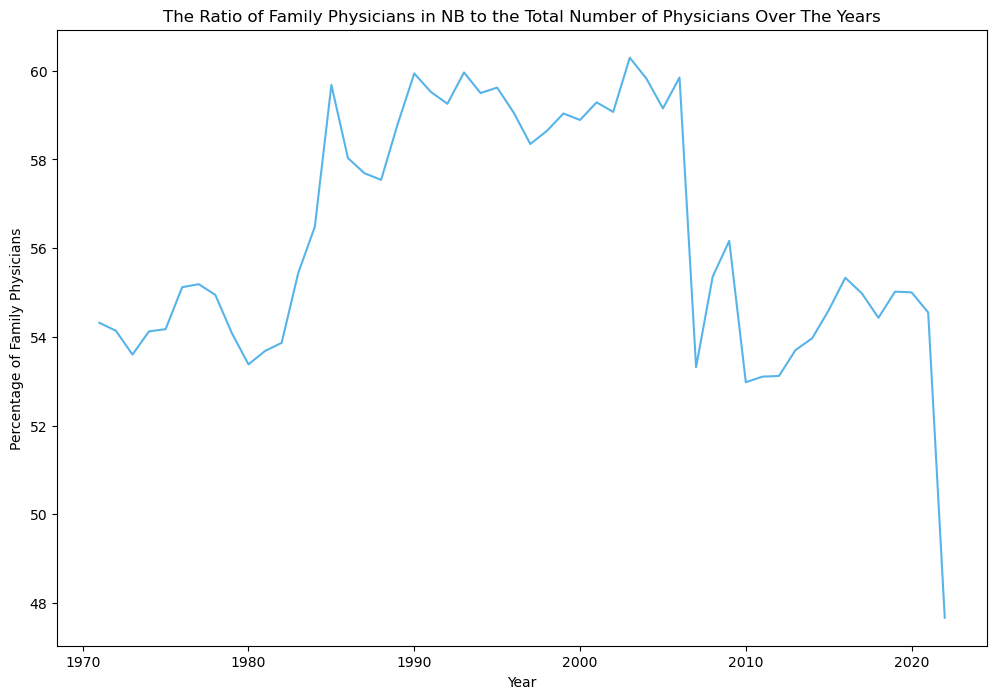

In [43]:
# Filter the dataframe for 'N.B.' jurisdiction and 'All physicians' specialty
nb_all_physicians_df= df[
    (df['Specialty sort'] == 1) & 
    (((df['Jurisdiction'] == 'N.B.') & (df['Health region'] == 'N.B.'))
    )]

# Filter the dataframe for 'N.B.' jurisdiction and 'Family medicine' specialty
nb_family_medicine_df = df[
    (df['Specialty sort'] == 3) & 
    (((df['Jurisdiction'] == 'N.B.') & (df['Health region'] == 'N.B.'))
    )]

# Group by year and sum the number of physicians for each specialty
nb_all_physicians_by_year = nb_all_physicians_df.groupby('Year')['Number of physicians'].sum()
nb_family_medicine_by_year = nb_family_medicine_df.groupby('Year')['Number of physicians'].sum()

# Calculate the percentage of family physicians to total physicians
percentage_family_medicine = (nb_family_medicine_by_year / nb_all_physicians_by_year) * 100

# Plotting
plt.figure(figsize=(12, 8))

# Plot percentage of family physicians to total physicians in 'N.B.'
plt.plot(percentage_family_medicine.index, percentage_family_medicine.values, color='#56B4E9', label='Percentage of Family Physicians to Total Physicians')


# Add data labels for the first and last years
#plt.text(percentage_family_medicine.index[0], percentage_family_medicine.values[0], f'{percentage_family_medicine.values[0]:.2f}%', ha='right', va='bottom')
#plt.text(percentage_family_medicine.index[-1], percentage_family_medicine.values[-1], f'{percentage_family_medicine.values[-1]:.2f}%', ha='right', va='bottom')

plt.title('The Ratio of Family Physicians in NB to the Total Number of Physicians Over The Years')
plt.xlabel('Year')
plt.ylabel('Percentage of Family Physicians')
plt.grid(False)
plt.show()



C:\Users\marie\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\marie\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Top correlations with 'Number of physicians' column:
Physician-to–100,000 population ratio                            0.998833
Place of MD graduation: Canada                                   0.997345
Year                                                             0.991638
Number female                                                    0.988548
Percentage female                                                0.984884
Percentage male                                                  0.978482
Number in urban areas                                            0.976229
University of graduation: Memorial University                    0.976229
Median years since graduation                                    0.972624
University of graduation: University of Montréal                 0.971112
Average age                                                      0.959576
Years since graduation: 31–35                                    0.956526
Median age                                                 

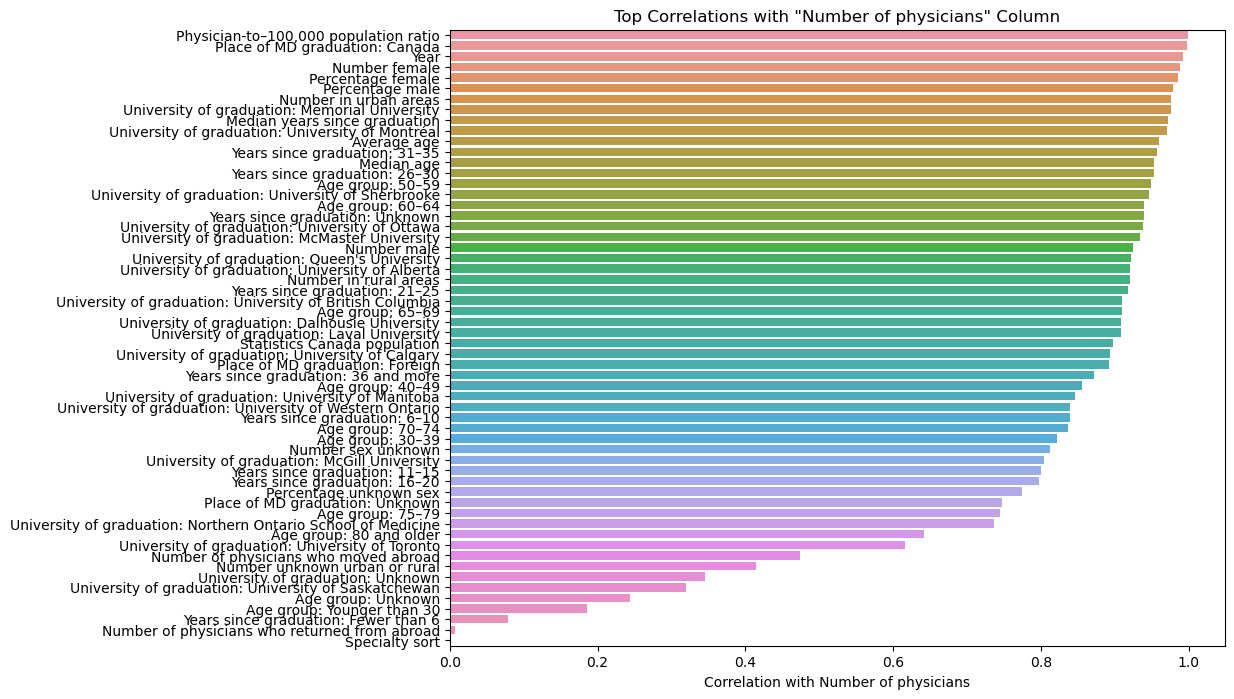

In [49]:
# Investigate best features of family_medicine_df_nb Dataframe for machine learning

# Filter the DataFrame to include only numeric columns
numeric_cols = family_medicine_df_nb.select_dtypes(include=['number'])

# Select the 'Number of physicians' column
target_column = 'Number of physicians'

# Calculate correlations of 'Number of physicians' with all other numeric columns
correlations = numeric_cols.corrwith(numeric_cols[target_column])

# Sort correlations in descending order
sorted_correlations = correlations.abs().sort_values(ascending=False)

# Filter only the top correlated columns (excluding the column itself)
top_correlations = sorted_correlations[sorted_correlations.index != target_column]

# Print the top correlated columns
print("Top correlations with '{}' column:".format(target_column))
print(top_correlations)

# Plotting the correlations with a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x=top_correlations.values, y=top_correlations.index)
plt.xlabel('Correlation with {}'.format(target_column))
plt.title('Top Correlations with "{}" Column'.format(target_column))
plt.show()


ADF Statistic: 0.023263
p-value: 0.960414
Fail to reject the null hypothesis, the time series is non-stationary, p value greater than 0.05 
ADF Statistic (after differencing): -7.763177
p-value: 0.000000
After one differencing we achieve stationarity, d is equal to 1. 


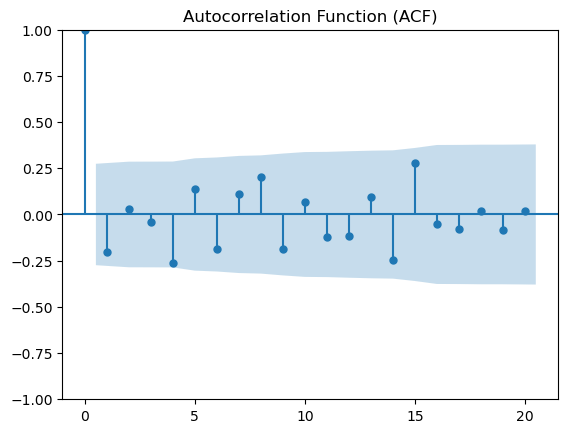

q value is equal to 1


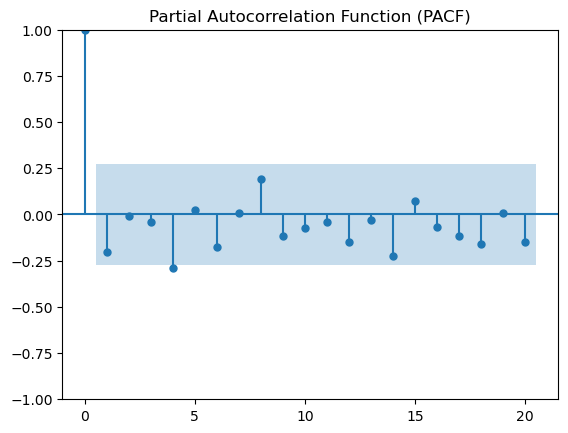

p value is equal to 1


In [45]:
# Since the goal is to predict future numbers of physicians, I won't focus on finding the best features from the dataset and move on to a Time series forecasting model
# I am choosing to go with ARIMA model, as it take past time series values to predict future data. 

# Must define the 3 parameters of ARIMA model (p,d,q) p:autoregressive order, d:difference order, q:moving order. 

# Test whether the series is stationary or non-stationary :  d parameter 
#  Augmented Dickey-Fuller Test : significance level a, 0.05. 
#H₀ (Null hypothesis) = Time series non-stationary 
#H₁ (Alternative hypothesis) = Time series is stationary
adf_test = adfuller(family_medicine_df_nb['Number of physicians'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print("Fail to reject the null hypothesis, the time series is non-stationary, p value greater than 0.05 ")

# apply first differencing transformation
diff_data = family_medicine_df_nb['Number of physicians'].diff().dropna()
# Perform ADF test on the differenced series
adf_test_diff = adfuller(diff_data)
# Output the results
print('ADF Statistic (after differencing): %f' % adf_test_diff[0])
print('p-value: %f' % adf_test_diff[1])
print("After one differencing we achieve stationarity, d is equal to 1. ")

# ACF plot to determine q value
sm.graphics.tsa.plot_acf(diff_data, lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()
print("q value is equal to 1")

# PACF plot to determine p value
sm.graphics.tsa.plot_pacf(diff_data, lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()
print("p value is equal to 1")

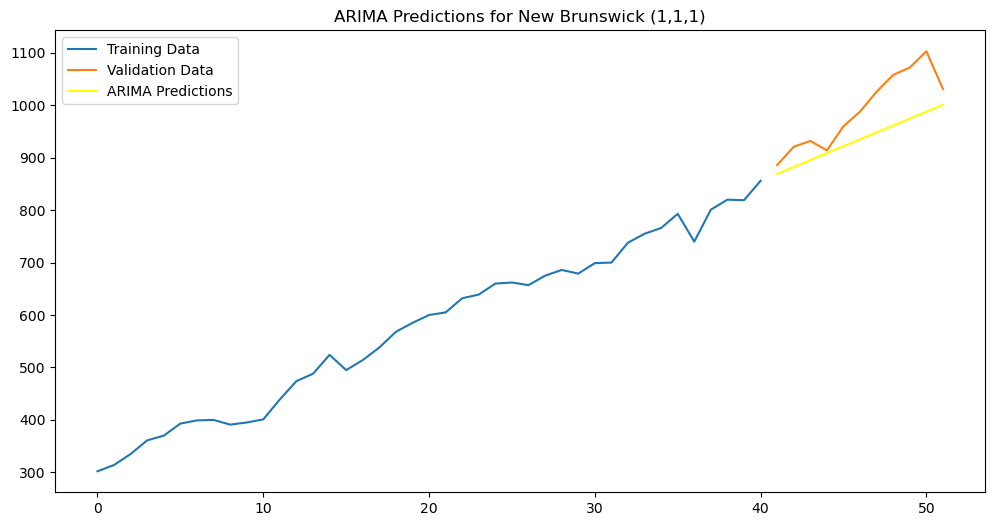

RMSE:  65.01411891897584


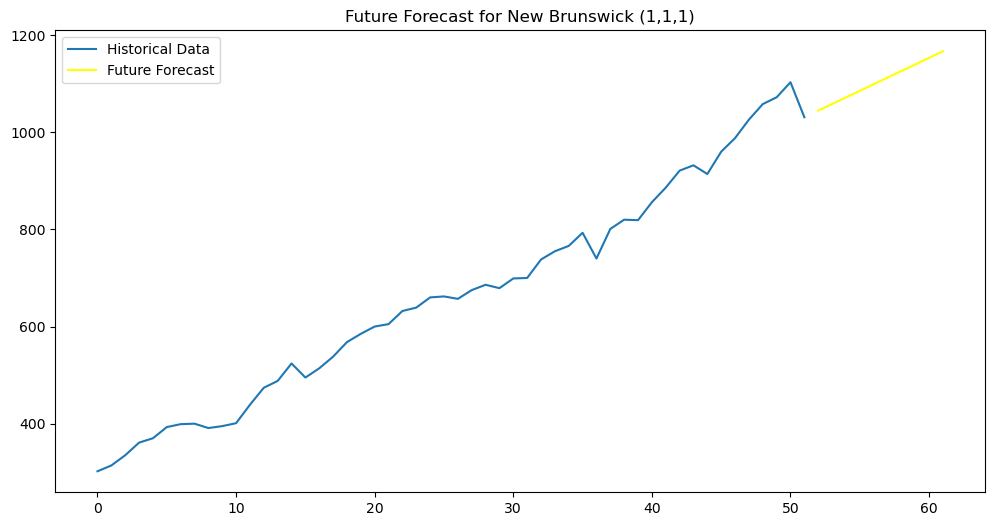

In [46]:
# Sort the dataframe by year and reset the index
family_medicine_df_nb = family_medicine_df_nb.sort_values('Year').reset_index(drop=True)

# Extract the 'Number of physicians' column
data = family_medicine_df_nb['Number of physicians']

# Split data into train and validation sets
train_size = int(len(data) * 0.8)
train, validation = data[:train_size], data[train_size:]

# Fit the ARIMA model
ARIMAmodel = ARIMA(train, order=(1, 1, 1))
ARIMAmodel = ARIMAmodel.fit()

# Make predictions on the validation set
y_pred = ARIMAmodel.get_forecast(steps=len(validation))
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df["Predictions"] = ARIMAmodel.predict(start=validation.index[0], end=validation.index[-1])
y_pred_df.index = validation.index
y_pred_out = y_pred_df["Predictions"]

# Plotting
plt.figure(figsize=(12, 6))
plt.title('ARIMA Predictions for New Brunswick (1,1,1)')
plt.plot(train, label='Training Data')
plt.plot(validation, label='Validation Data')
plt.plot(y_pred_out, color='yellow', label='ARIMA Predictions')
plt.legend()
plt.show()

# Calculate RMSE
arma_rmse = np.sqrt(mean_squared_error(validation.values, y_pred_out))
print("RMSE: ", arma_rmse)

# fit it on the entire dataset
ARIMAmodel_full = ARIMA(data, order=(1, 1, 1))
ARIMAmodel_full = ARIMAmodel_full.fit()

# Forecast future values
forecast_steps = 10  # Number of future periods to forecast
future_forecast = ARIMAmodel_full.get_forecast(steps=forecast_steps)
future_forecast_df = future_forecast.conf_int(alpha=0.05)
future_forecast_df["Predictions"] = ARIMAmodel_full.predict(start=len(data), end=len(data) + forecast_steps - 1)

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.title('Future Forecast for New Brunswick (1,1,1)')
plt.plot(data, label='Historical Data')
plt.plot(range(len(data), len(data) + forecast_steps), future_forecast_df["Predictions"], color='yellow', label='Future Forecast')
plt.legend()
plt.show()

ARIMA(0, 0, 0) RMSE=418.5866473822011
ARIMA(0, 0, 1) RMSE=411.02414157451085
ARIMA(0, 0, 2) RMSE=401.96683958361064
ARIMA(0, 1, 0) RMSE=150.90605144803294
ARIMA(0, 1, 1) RMSE=148.70074710593383
ARIMA(0, 1, 2) RMSE=164.34234230351169
ARIMA(0, 2, 0) RMSE=105.96526017350598
ARIMA(0, 2, 1) RMSE=60.83280452251429
ARIMA(0, 2, 2) RMSE=68.25384715986256
ARIMA(1, 0, 0) RMSE=158.3180055404624
ARIMA(1, 0, 1) RMSE=157.0581984611855
ARIMA(1, 0, 2) RMSE=180.8555734736873
ARIMA(1, 1, 0) RMSE=146.87128750057596
ARIMA(1, 1, 1) RMSE=65.01411891897584
ARIMA(1, 1, 2) RMSE=163.39170793306144
ARIMA(1, 2, 0) RMSE=27.919699027828877
ARIMA(1, 2, 1) RMSE=66.4029024046678
ARIMA(1, 2, 2) RMSE=70.3816806535317
ARIMA(2, 0, 0) RMSE=156.07154469830326
ARIMA(2, 0, 1) RMSE=158.0963276995034
ARIMA(2, 0, 2) RMSE=180.9027397885611
ARIMA(2, 1, 0) RMSE=129.86895342407857
ARIMA(2, 1, 1) RMSE=68.72812518451289
ARIMA(2, 1, 2) RMSE=70.74741014472218
ARIMA(2, 2, 0) RMSE=38.42435406527627
ARIMA(2, 2, 1) RMSE=62.89710100610015
ARI

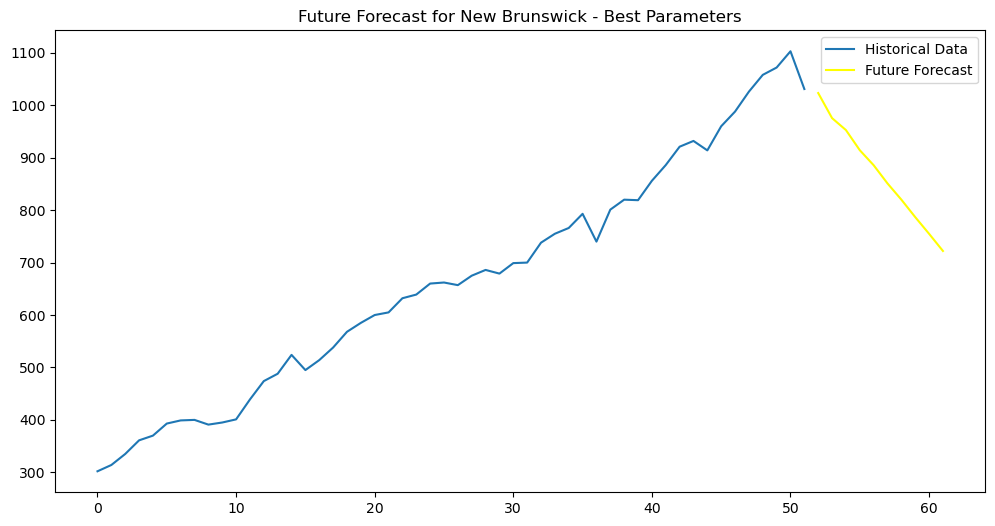

In [47]:
#Trying the gridseach approach to find the best parameters (p,d,q) to fit the ARIMA model 

# Define a function to evaluate ARIMA model
def evaluate_arima_model(train, validation, arima_order):
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    y_pred = model_fit.get_forecast(steps=len(validation))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df["Predictions"] = model_fit.predict(start=validation.index[0], end=validation.index[-1])
    y_pred_df.index = validation.index
    y_pred_out = y_pred_df["Predictions"]
    rmse = np.sqrt(mean_squared_error(validation.values, y_pred_out))
    return rmse

# Grid search for ARIMA hyperparameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
best_score, best_cfg = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                rmse = evaluate_arima_model(train, validation, order)
                if rmse < best_score: best_score, best_cfg = rmse, order
                print(f'ARIMA{order} RMSE={rmse}')
            except:
                continue

print(f'Best ARIMA{best_cfg} RMSE={best_score}')

# Fit the best model on the entire dataset and forecast future values
best_model = ARIMA(data, order=best_cfg)
best_model_fit = best_model.fit()

# Forecast future values
forecast_steps = 10
future_forecast = best_model_fit.get_forecast(steps=forecast_steps)
future_forecast_df = future_forecast.conf_int(alpha=0.05)
future_forecast_df["Predictions"] = best_model_fit.predict(start=len(data), end=len(data) + forecast_steps - 1)

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical Data')
plt.title('Future Forecast for New Brunswick - Best Parameters')
plt.plot(range(len(data), len(data) + forecast_steps), future_forecast_df["Predictions"], color='yellow', label='Future Forecast')
plt.legend()
plt.show()

RMSE:  65.01411891897584


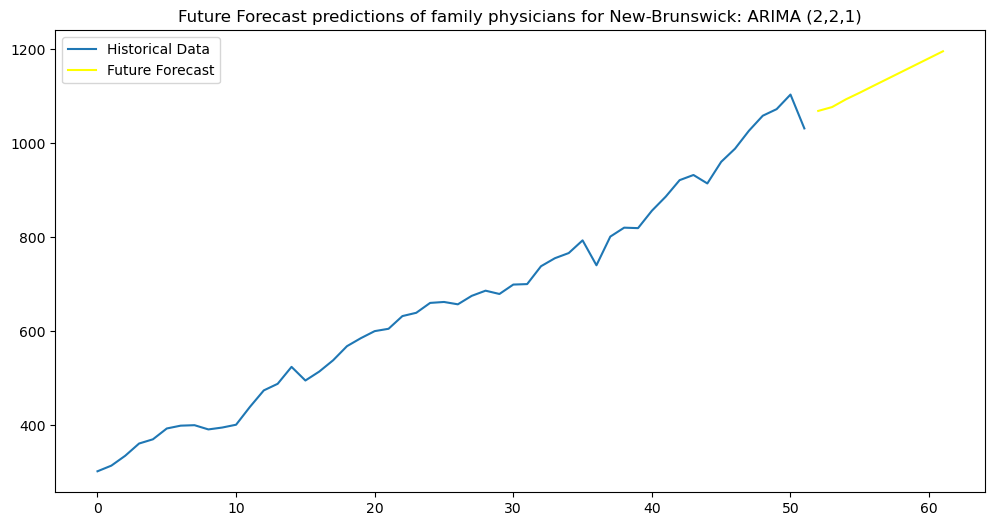

RMSE:  65.01411891897584


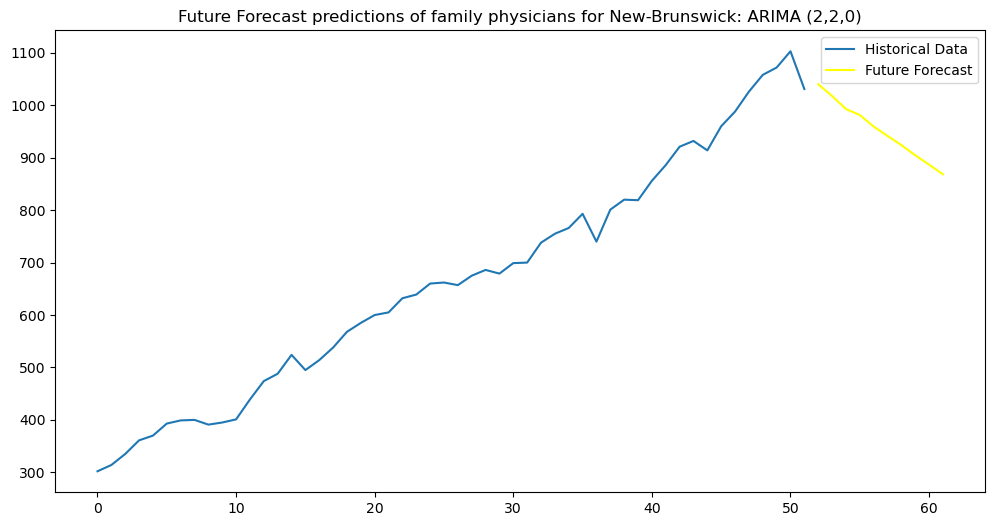

In [48]:
# Based on the results of the gridsearch, testing alternative parameters (2,2,0) and (2,2,1)

## (2,2,1) ##
# Calculate RMSE
arma_rmse = np.sqrt(mean_squared_error(validation.values, y_pred_out))
print("RMSE: ", arma_rmse)

# fit it on the entire dataset
ARIMAmodel_full = ARIMA(data, order=(2, 2, 1))
ARIMAmodel_full = ARIMAmodel_full.fit()

# Forecast future values
forecast_steps = 10  # Number of future periods to forecast
future_forecast = ARIMAmodel_full.get_forecast(steps=forecast_steps)
future_forecast_df = future_forecast.conf_int(alpha=0.05)
future_forecast_df["Predictions"] = ARIMAmodel_full.predict(start=len(data), end=len(data) + forecast_steps - 1)

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical Data')
plt.title(f'Future Forecast predictions of family physicians for New-Brunswick: ARIMA (2,2,1)')
plt.plot(range(len(data), len(data) + forecast_steps), future_forecast_df["Predictions"], color='yellow', label='Future Forecast')
plt.legend()
plt.show()

## (2,2,0) ##
# Calculate RMSE
arma_rmse2 = np.sqrt(mean_squared_error(validation.values, y_pred_out))
print("RMSE: ", arma_rmse2)

# fit it on the entire dataset
ARIMAmodel_full = ARIMA(data, order=(2, 2, 0))
ARIMAmodel_full = ARIMAmodel_full.fit()

# Forecast future values
forecast_steps = 10  # Number of future periods to forecast
future_forecast = ARIMAmodel_full.get_forecast(steps=forecast_steps)
future_forecast_df = future_forecast.conf_int(alpha=0.05)
future_forecast_df["Predictions"] = ARIMAmodel_full.predict(start=len(data), end=len(data) + forecast_steps - 1)

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical Data')
plt.title(f'Future Forecast predictions of family physicians for New-Brunswick: ARIMA (2,2,0)')
plt.plot(range(len(data), len(data) + forecast_steps), future_forecast_df["Predictions"], color='yellow', label='Future Forecast')
plt.legend()
plt.show()